# Лаб 5: Робота з бібліотекою OpenCV

### Завдання:

    Примітки

    1. При зменшенні зображення помістити обличчя в центрі картинки.
    2. Для визначення обличчя та очей використати Haar Cascade з бібліотеки 
    OpenCV.
    3. Для малювання використати бібліотеки PIL та/або OpenCV (за бажанням)

### 1. Визначити номер варіанта за формулою:

        N = ord(X) % 5 + 1, 

        де X – перша велика літера вашого імені в латинській транскрипції. 

In [1]:
N = ord("V") % 5 + 1
print(f"Жарий Вадим. Варіант: {N}")

Жарий Вадим. Варіант: 2


### 2. Завантажити дані з файлу kr1.xlsx до датафрейму.

In [2]:
import pandas as pd
df = pd.read_excel('lab5.xlsx')
df

,N,file name,image size,glasses color,line width
0,1,emma-watson2.jpg,300x300,red,2
1,2,emma-watson.jpg,400x400,blue,3
2,3,draco.jpg,700x700,cyan,4
3,4,longbottom.jpg,600x600,magenta,5
4,5,ron_wesley.jpg,500x500,yellow,6


### 3. Отримати дані до свого варіанту програмно з датафрейму

In [3]:
my_df = df.loc[1]
my_df

N                              2
file name        emma-watson.jpg
image size               400x400
glasses color               blue
line width                     3
Name: 1, dtype: object

### 4. Створити функцію, що приймає в якості аргументів дані з датафрейму та повертає зменшене зображення з доданими «круглими окулярами» та зберігає отримане зображення у файл.

In [15]:
import cv2
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

def process_image_with_glasses(row_data):
    # Отримуємо параметри з даних
    file_name = row_data['file name']
    glasses_color = row_data['glasses color']    
    line_width = int(row_data['line width'])
    target_size = tuple(map(int, row_data['image size'].split('x')))

    # Завантажуємо зображення
    image_path = f'./Images/{file_name}'
    img = cv2.imread(image_path)
    if img is None:
        print(f"Файл {file_name} не знайдено.")
        return None

    # Перетворюємо колір окулярів у формат BGR
    rgb = mcolors.to_rgb(glasses_color)
    color = tuple(int(c * 255) for c in reversed(rgb))

    # Завантажуємо класифікатори для виявлення обличчя та очей
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Конвертуємо зображення в відтінки сірого для детектування обличчя
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    
    # Обробка знайденого обличчя
    for (x, y, w, h) in faces:
        # Визначаємо додаткові пікселі для обрізки, щоб центроване обличчя залишилося
        target_width, target_height = target_size
        additional_w = max((target_width - w) // 2, 0)
        additional_h = max((target_height - h) // 2, 0)

        # Встановлюємо межі обрізки, щоб обличчя було в центрі
        start_x = max(x - additional_w, 0)
        start_y = max(y - additional_h, 0)
        end_x = min(x + w + additional_w, img.shape[1])
        end_y = min(y + h + additional_h, img.shape[0])

        # Обрізаємо зображення та змінюємо розмір до цільового
        img_cropped = img[start_y:end_y, start_x:end_x]
        img_resized = cv2.resize(img_cropped, target_size)

        # Підготовка для пошуку очей - виділяємо ліву та праву частини обличчя
        face_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        face_height, face_width = face_gray.shape
        left_face = face_gray[0:int(face_height * 0.6), 0:int(face_width / 2)]
        right_face = face_gray[0:int(face_height * 0.6), int(face_width / 2):face_width]

        # Пошук очей на кожній половині обличчя
        left_eye = eye_cascade.detectMultiScale(left_face, scaleFactor=1.1, minNeighbors=10)
        right_eye = eye_cascade.detectMultiScale(right_face, scaleFactor=1.1, minNeighbors=10)

        # Якщо очі знайдено, малюємо окуляри
        if len(left_eye) > 0 and len(right_eye) > 0:
            lx, ly, lw, lh = left_eye[0]
            rx, ry, rw, rh = right_eye[0]

            # Центри та радіус для окулярів
            center_left = (lx + lw // 2, ly + lh // 2)
            center_right = (face_width // 2 + rx + rw // 2, ry + rh // 2)
            radius = int(min(lw, rw) * 0.7)

            # Малюємо круги для окулярів
            cv2.circle(img_resized, center_left, radius, color, line_width)
            cv2.circle(img_resized, center_right, radius, color, line_width)

            # Малюємо перенісся між кругами окулярів
            nose_bridge_start = (center_left[0] + radius, center_left[1])
            nose_bridge_end = (center_right[0] - radius, center_right[1])
            cv2.line(img_resized, nose_bridge_start, nose_bridge_end, color, line_width)

            # Малюємо дужки окулярів, починаючи від країв кругів
            cv2.line(img_resized, (center_left[0] - radius, center_left[1]),
                     (center_left[0] - radius - 30, center_left[1]), color, line_width)
            cv2.line(img_resized, (center_right[0] + radius, center_right[1]),
                     (center_right[0] + radius + 30, center_right[1]), color, line_width)

    # Зберігаємо результат та виводимо повідомлення про успішне збереження
    output_file = f"processed_{file_name}"
    cv2.imwrite(output_file, img_resized)
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    print(f"Оброблене зображення збережено як {output_file}")
    return img_resized

Оброблене зображення збережено як processed_emma-watson.jpg


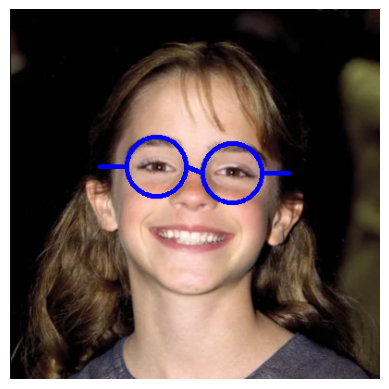

In [16]:
processed_image = process_image_with_glasses(my_df)
plt.imshow(processed_image)
plt.axis('off')
plt.show()

Оброблене зображення збережено як processed_emma-watson2.jpg


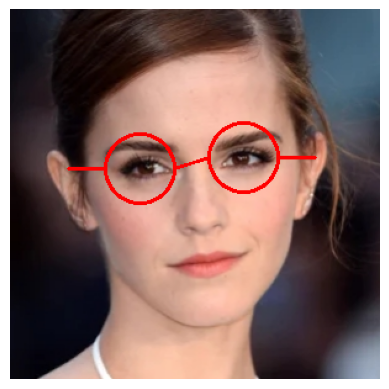

In [17]:
test_df = df.loc[0]
processed_image = process_image_with_glasses(test_df)
plt.imshow(processed_image)
plt.axis('off')
plt.show()

Оброблене зображення збережено як processed_draco.jpg


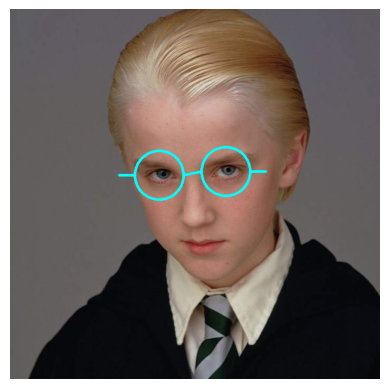

In [18]:
test_df = df.loc[2]
processed_image = process_image_with_glasses(test_df)
plt.imshow(processed_image)
plt.axis('off')
plt.show()

Оброблене зображення збережено як processed_longbottom.jpg


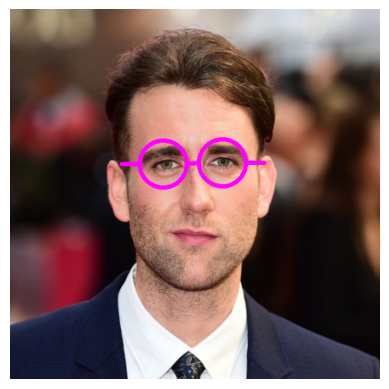

In [19]:
test_df = df.loc[3]
processed_image = process_image_with_glasses(test_df)
plt.imshow(processed_image)
plt.axis('off')
plt.show()

Оброблене зображення збережено як processed_ron_wesley.jpg


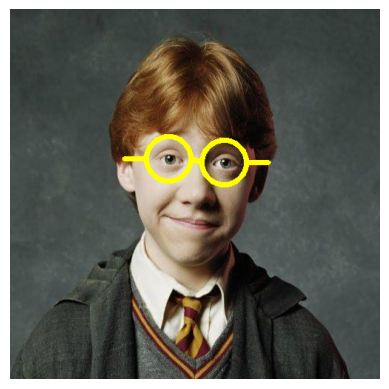

In [20]:
test_df = df.loc[4]
processed_image = process_image_with_glasses(test_df)
plt.imshow(processed_image)
plt.axis('off')
plt.show()